In [1]:
import numpy as np
import pandas as pd 
import os

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
from torchvision.models.resnet import ResNet, Bottleneck
from torchvision.models import ResNet50_Weights

# NTXentLoss

In [3]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="mean")

    def forward(self, z_i, z_j):
        N = z_i.size(0)
        
        z = torch.cat([z_i, z_j], dim=0)  
        
        z = torch.nn.functional.normalize(z, dim=1)
        sim = torch.matmul(z, z.T) / self.temperature  

        
        mask = torch.eye(2 * N, dtype=torch.bool, device=z.device)
        sim.masked_fill_(mask, -1e9)

        pos_idx = torch.arange(N, device=z.device)
        labels = torch.cat([pos_idx + N, pos_idx])

        loss = self.criterion(sim, labels)
        return loss

# Modified Resnet Model

In [4]:
class ModifiedResnet(ResNet):
    def __init__(self, pretrained=True):
        super(ModifiedResnet, self).__init__(block=Bottleneck, layers=[3, 4, 6, 3])
        
        # No downsampling on the first layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False)
        
        self.fc = nn.Identity()
        
        if pretrained:
            self.load_pretrained_weights()
            
    def load_pretrained_weights(self):
        weights = ResNet50_Weights.DEFAULT.get_state_dict(progress=True)
        self.load_state_dict(weights, strict=False)

In [5]:
class Model(nn.Module):
    def __init__(self, latent_dim=512):
        super(Model, self).__init__()
        
        self.resnet = ModifiedResnet()
        
        # Projection for a latent space
        self.projection = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, latent_dim)
        )
        
    def forward(self, x):
        x = self.resnet(x)
        latent_space =  self.projection(x)
        return latent_space
        

# Custom Dataset

In [6]:
class ContrastiveDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform1, transform2, transform3):
        self.dataset = dataset
        self.transform1 = transform1
        self.transform2 = transform2
        self.transform3 = transform3
        
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img1 = self.transform1(img)
        img2 = self.transform2(img)
        img3 = self.transform3(img)
        return img1, img2, img3  
    
    def __len__(self):
        return len(self.dataset)

In [6]:
transform = v2.Compose([
    v2.Resize((128, 128)),
    v2.ToTensor()
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [12]:
supervised_dataset = torchvision.datasets.ImageFolder('/kaggle/input/real-and-fake-images/dataset/train', transform=transform)

supervised_loader = torch.utils.data.DataLoader(supervised_dataset, batch_size=64, shuffle=True)

In [9]:
transform1 = v2.Compose([
    v2.Resize((128, 128)),
    v2.RandomResizedCrop((100, 100)),
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    v2.RandomGrayscale(p=0.2),
    v2.ToTensor(),
])

transform2 = v2.Compose([
    v2.Resize((128, 128)),
    v2.RandomResizedCrop((100, 100)),
    v2.RandomHorizontalFlip(),
    v2.GaussianBlur(kernel_size=3),
    v2.ToTensor(),
])

transform3 = v2.Compose([
    v2.Resize((128, 128)),
    v2.RandomResizedCrop((100, 100)),
    v2.RandomHorizontalFlip(),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.5),
    v2.RandomApply([v2.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
    v2.ToTensor(),
])

In [10]:
self_supervised_dataset = torchvision.datasets.ImageFolder('/kaggle/input/real-and-fake-images/dataset/train')

self_supervised_dataset = ContrastiveDataset(self_supervised_dataset, transform1, transform2, transform3)

In [11]:
self_supervised_loader = torch.utils.data.DataLoader(self_supervised_dataset, batch_size=64, shuffle=True)

# Training Process

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 512
epochs = 15

ntxent_loss = NTXentLoss(temperature=0.07)

model = Model(latent_dim).to(device)
classifier = nn.Linear(latent_dim, 2).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s] 


In [10]:
ss_optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

sup_optimizer = torch.optim.Adam(list(model.parameters()) + list(classifier.parameters()), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [11]:
def train_self_supervised(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    for batch in dataloader:
        
        img1, img2, _ = batch  
        img1 = img1.to(device)
        img2 = img2.to(device)

        
        z1 = model(img1)  
        z2 = model(img2)
        
       
        loss = criterion(z1, z2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    return running_loss

In [12]:
def train_supervised(model, classifier, dataloader, optimizer, criterion, device):
    model.train()
    classifier.train()
    running_loss = 0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        
        features = model(images)  
        
        outputs = classifier(features)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    return running_loss

In [19]:
for epoch in range(epochs):
    loss = train_self_supervised(model, self_supervised_loader, ss_optimizer, ntxent_loss, device)
    print(loss/len(self_supervised_loader))

3.0755775317896243
2.0354569446901944
1.5781539713227473
1.3072223240552947
1.1383082582507023
1.0314969245431036
0.9395976541347282
0.87453537313051
0.8275854064281597
0.7714535321953685
0.7359427840903748
0.697804240813089
0.6566378432650899
0.634604329459889
0.6215708933250849


In [20]:
torch.save(model.state_dict(), "cozzolino.pth")

In [23]:
for epoch in range(epochs):
    loss = train_supervised(model, classifier, supervised_loader, sup_optimizer, criterion, device)
    print(f"Epoch: {epoch}, Loss: {loss}")

Epoch: 0, Loss: 17.220285310060717
Epoch: 1, Loss: 4.531405952991918
Epoch: 2, Loss: 0.8966994476686523
Epoch: 3, Loss: 0.3721916503527609
Epoch: 4, Loss: 0.15820340602112992
Epoch: 5, Loss: 0.1261668994889078
Epoch: 6, Loss: 0.15492910566854334
Epoch: 7, Loss: 0.0901822637819123
Epoch: 8, Loss: 0.18042172795355782
Epoch: 9, Loss: 0.5140979836855877
Epoch: 10, Loss: 0.2582335917622345
Epoch: 11, Loss: 0.08152862732600852
Epoch: 12, Loss: 0.014460491096940586
Epoch: 13, Loss: 0.07266262805705992
Epoch: 14, Loss: 0.05164261807242099


In [25]:
torch.save(model.state_dict(), "cozzolino1_part_1.pth")

In [26]:
torch.save(classifier.state_dict(), "cozzolino1_part_2.pth")

## Loading and testing the model on a validation dataset (after training)

In [8]:
model.load_state_dict(torch.load("/kaggle/input/ganresnetclassifier/pytorch/default/1/model.pth", weights_only=True))
classifier.load_state_dict(torch.load("/kaggle/input/ganresnetclassifier/pytorch/default/1/classifier.pth", weights_only=True))

<All keys matched successfully>

In [9]:
val_dataset = torchvision.datasets.ImageFolder('/kaggle/input/real-and-fake-images/dataset/validation', transform=transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

In [10]:
print(val_dataset.class_to_idx)

{'fake_images': 0, 'real_images': 1}


In [11]:
with torch.no_grad():
    model.eval()
    classifier.eval()
    correct = 0
    total = 0
    for image, label in val_dataloader:
        image, label = image.to(device), label.to(device)
        features = model(image)

        out = classifier(features)
        
        _, predicted = torch.max(out, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    val_acc = correct/total
    print(f"Validation Score: {val_acc}")

Validation Score: 0.9484871217804451


In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for image, label in val_dataloader:
        image, label = image.to(device), label.to(device).float()
        
        features = model(image)
        out = classifier(features)
        _, predicted = torch.max(out, 1)
        
        all_preds.append(predicted.cpu())
        all_labels.append(label.cpu().long())

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_labels).numpy()

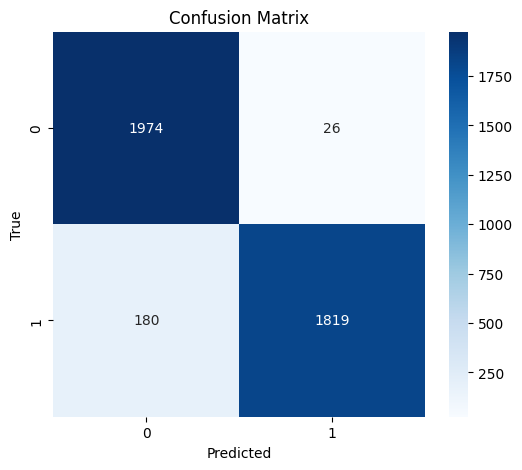

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='weighted')  # ou 'macro', 'micro' dependendo do que quiser
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Precision: 0.9512
Recall: 0.9485
F1-score: 0.9484
